## Bitcoin Price Forecasting with Machine Learning
### Version 2: Application of Long Short Term Memory (LSTM) Model with Feature Engineering

This notebook demonstrates the process of forecasting Bitcoin prices using machine learning techniques. We will go through the following steps:
1. Loading and exploring the dataset
2. Feature Engineering
3. Normalization
4. Splitting the data into training and testing sets
5. Creation of the LSTM Model
6. Evaluating the model
7. Forecasting future prices

Data source: `https://www.investing.com/crypto/bitcoin/historical-data`

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import joblib

import warnings
warnings.filterwarnings("ignore")

## Step 1: Load and Explore the Data

First, we'll load the dataset and explore its structure.

In [2]:
# Load and sort the data
data = pd.read_csv('./datasets/coin_Bitcoin_full.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()

## Step 2: Feature Engineering

### Moving Averages
#### Purpose: 
- To smooth out short-term fluctuations and highlight longer-term trends or cycles.

#### How it helps:
1. Trend Detection: Moving averages help in identifying the underlying trend direction of the data, whether it's up, down, or sideways.
2. Noise Reduction: Averaging out the data points over a time period, there is the reduction of the impact of random fluctuations (noise) (making it easier to observe the true movement of the price).
3. Support and Resistance Levels: In trading, moving averages often act as support and resistance levels. This can be useful in predicting potential future price movements based on historical data.

### Price Changes (Daily Change)
#### Purpose: 
- To measure the rate of change in price, which helps in understanding the momentum of price movements.

#### How it helps:
- Momentum Indicators: The daily percentage change gives an idea of the momentum in the market. Higher momentum could indicate a strong trend, while lower momentum might suggest a weakening trend.

### Volatility Insight: 
Trend Reversal Signals: Significant changes in the daily price can sometimes indicate potential trend reversals or confirm the continuation of a trend.
#### Purpose:
- Observing the magnitude of daily changes helps in assessing the market's volatility. Large price changes indicate high volatility, while small changes suggest low volatility.
- To measure the degree of variation in trading prices over time, which indicates the level of market risk and uncertainty.

#### How it helps:
1. Risk Assessment: Volatility is a key measure of risk in financial markets. High volatility indicates higher risk and uncertainty, while low volatility suggests stability.
2. Market Sentiment: Volatility can reflect market sentiment. High volatility often accompanies market panic or euphoria, while low volatility is seen in more stable, confident market conditions.
3. Forecasting: Including volatility in the model helps capture periods of market turbulence or calmness, improving the model's ability to make accurate predictions under varying market conditions.

## Summary
Incorporating these elements into your model helps capture a more comprehensive picture of the market dynamics:

1. Moving Averages: Capture long-term trends and reduce noise.
2. Price Changes: Provide insights into momentum and potential trend reversals.
3. Volatility Index: Assess market risk and improve the model's responsiveness to different market conditions.

- By considering these factors, our predictive model becomes more robust and capable of making more accurate forecasts.

In [3]:
# Feature engineering
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['14_day_MA'] = data['Close'].rolling(window=14).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['Daily_Change'] = data['Close'].pct_change()
data['Volatility'] = data['Close'].rolling(window=7).std()

# Drop the NaN values created by the rolling averages
data = data.dropna()

In [4]:
# Select features and target variable
features = data[['Close', '7_day_MA', '14_day_MA', '30_day_MA', 'Daily_Change', 'Volatility']]
target = data['Close']

## Step 3: Normalization of the data
Next, we'll Normalize the data then split it 80/20 as training and testing sets.

In [5]:
# Separate scaler for Close prices
close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(target.values.reshape(-1, 1))

# Normalization for other features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

## Step 4: Train-Test Split
We will split the data into training and testing sets. We'll use the last year in the dataset for testing.

In [6]:
# Split the data into training and testing sets
train_size = int(len(scaled_features) * 0.8)
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_close, test_close = scaled_close[:train_size], scaled_close[train_size:]

## Step 5: Creation of the LSTM Model

- LSTM models are well-suited for financial time series prediction because of their ability to:
    1. Handle sequential data, remember long-term dependencies
    2. Adapt to the volatile nature of financial markets.
- Thus LSTM networks can provide more accurate and reliable predictions for Bitcoin prices.

In [7]:
# Reshape data for LSTM model
train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))

In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(1, train_features.shape[2])))
model.add(LSTM(units=100))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_features, train_close, epochs=20, batch_size=32)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0229
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4790e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0572e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6150e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2589e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0199e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3669e-05
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0995e-05
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7118e-05
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6136e-05
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9699e-05
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5627e-05
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5431e-05
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3492e-05
Epoch

## Step 6: Evaluate the Model
We will evaluate the model by predicting the Bitcoin prices on the test set and calculating the RMSE. We will also visualize the actual vs. predicted prices from both train and test.

In [9]:
# Predict Close prices
predicted_scaled_close = model.predict(test_features)

# Inverse transform the predicted Close prices
predicted_close = close_scaler.inverse_transform(predicted_scaled_close)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_close, predicted_scaled_close))
print(f"Root Mean Squared Error: {rmse}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Root Mean Squared Error: 0.0033360971337467213


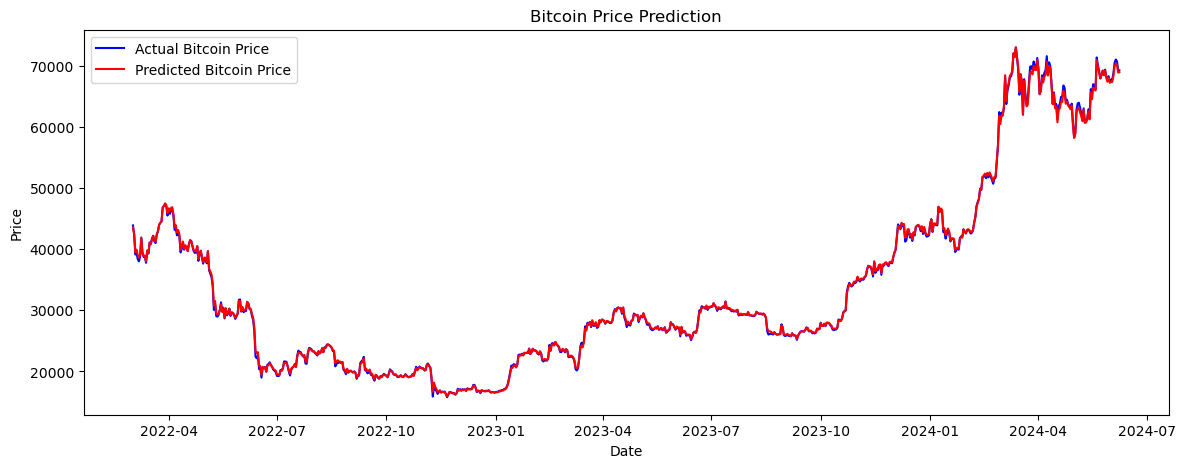

In [10]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size:], close_scaler.inverse_transform(test_close), color='blue', label='Actual Bitcoin Price')
plt.plot(data.index[train_size:], predicted_close, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Step 7: Forecast Future Prices
Finally, we will forecast the Bitcoin prices for the next year using the trained model.

In [11]:
# Save the model
model.save('./models/bitcoin_price_prediction.h5')

# Save the scalers
joblib.dump(close_scaler, './models/close_scaler.pkl')
joblib.dump(scaler, './models/scaler.pkl')

# Save the data
data.to_csv('./datasets/processed_data.csv')

In [12]:
# Apply the model to predict future prices for the next 90 days
future_features_90 = features[-90:]
future_features_90 = scaler.transform(future_features_90)
future_features_90 = future_features_90.reshape((future_features_90.shape[0], 1, future_features_90.shape[1]))
future_close_90 = model.predict(future_features_90)
future_close_90 = close_scaler.inverse_transform(future_close_90)

# Create a DataFrame for the future prices
future_dates_90 = pd.date_range(start=data.index[-1], periods=91, freq='D')[1:]
future_prices_90 = pd.DataFrame(future_close_90, index=future_dates_90, columns=['Close'])
future_prices_90.head()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Close
2024-06-09,72083.156250
2024-06-10,71476.054688
2024-06-11,73096.960938
2024-06-12,71503.234375
2024-06-13,69746.210938


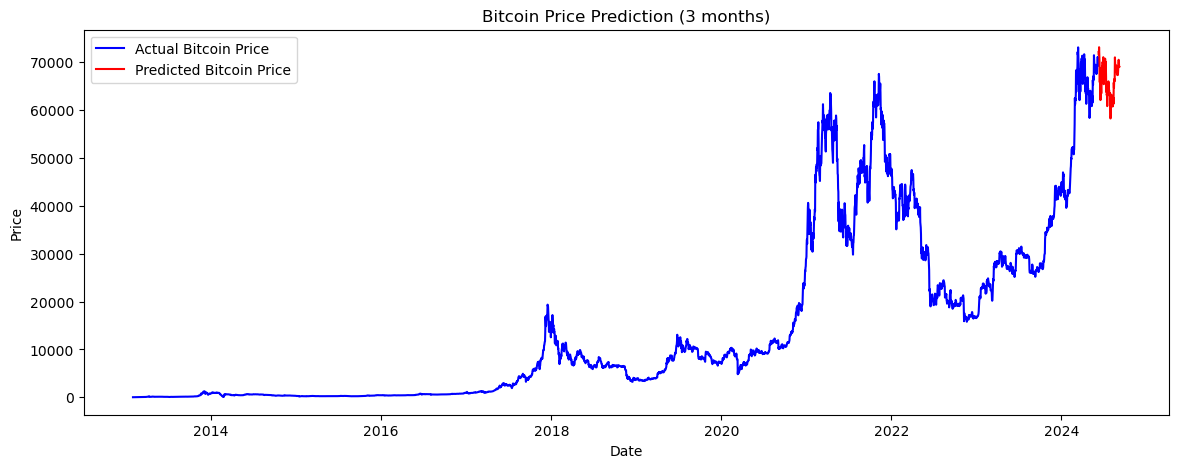

In [13]:
# Plot the actual and predicted prices for the next 90 days
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Close'], color='blue', label='Actual Bitcoin Price')
plt.plot(future_prices_90.index, future_prices_90, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (3 months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
# Apply the model to predict future prices for the next 60 days
future_features_60 = features[-60:]
future_features_60 = scaler.transform(future_features_60)
future_features_60 = future_features_60.reshape((future_features_60.shape[0], 1, future_features_60.shape[1]))
future_close_60 = model.predict(future_features_60)
future_close_60 = close_scaler.inverse_transform(future_close_60)

# Create a DataFrame for the future prices
future_dates_60 = pd.date_range(start=data.index[-1], periods=61, freq='D')[1:]
future_prices_60 = pd.DataFrame(future_close_60, index=future_dates_60, columns=['Close'])
future_prices_60.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Close
2024-06-09,70078.109375
2024-06-10,69511.492188
2024-06-11,66913.539062
2024-06-12,63759.195312
2024-06-13,65496.437500


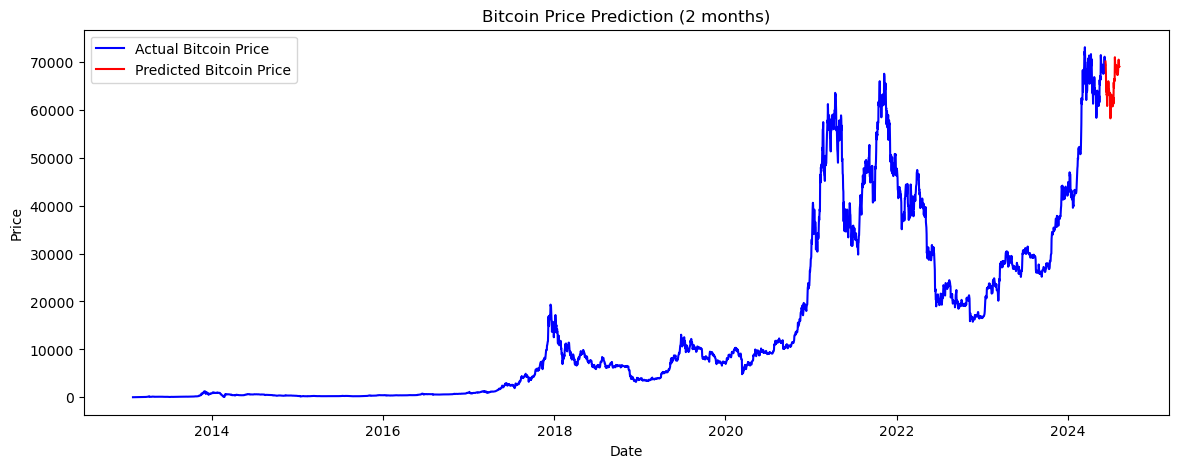

In [15]:
# Plot the actual and predicted prices for the next 60 days
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Close'], color='blue', label='Actual Bitcoin Price')
plt.plot(future_prices_60.index, future_prices_60['Close'], color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (2 months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

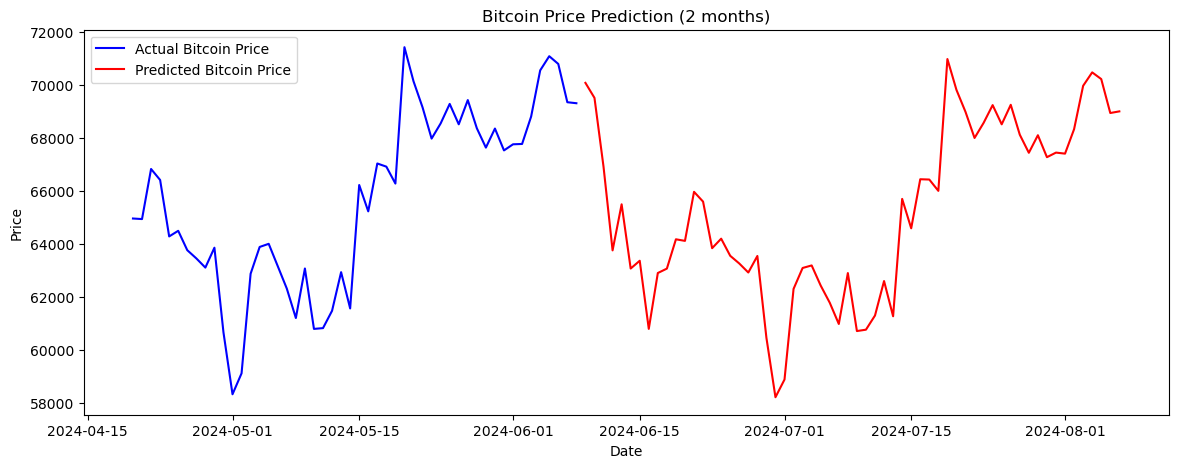

In [20]:
# Plot the actual and predicted prices for the next 60 days (zoomed in from 2024)
plt.figure(figsize=(14, 5))
plt.plot(data.index[-50:], data['Close'][-50:], color='blue', label='Actual Bitcoin Price')
plt.plot(future_prices_60.index, future_prices_60['Close'], color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (2 months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In this final step, we generate future dates and use the trained model to predict Bitcoin prices for the next year. We also plot the predicted future prices to visualize the forecast.

Parameter and Feature adjustment can be further applied to imporve the model's performance.

We note that the first few days in the `90` and `60` days predictions are close to the actual prices while the more we reduce the `future_features` prediction size we note prices further from the actual predictions.

It is also noted that in all prediction periods the prices drop significantly over time in an unusual manner.